# BAYES version of the Progression models for repeated measures

See https://arxiv.org/pdf/2203.15555.pdf 

To generate test data run `Rscript prepare_sim_data.R`

In [1]:
# Import packages
import math
import os
import logging
import warnings
import re  

import matplotlib
matplotlib.use('Cairo')

# visualization for Bayesian model output
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np # do we need this?
import jax.numpy as jnp
import jax

from jax import lax, random
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer import init_to_value, log_likelihood
from numpyro.diagnostics import hpdi

## for model
import numpyro.distributions as dist

# for storing data
import pyarrow.feather as feather

## colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# spline for NumPYRO
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline


In [2]:
# setup matplotlib
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png2x')

%matplotlib inline

sns.set_context('notebook')
sns.set_style("ticks")

In [3]:
# setup numpyro
if True:
    numpyro.set_platform("cpu")
    numpyro.enable_x64()
    numpyro.set_host_device_count(8)

print("Local devices:",jax.local_devices())
print("count:",jax.local_device_count())

rng_key = random.PRNGKey(0)
rng_key, rng_key_,rng_key_2 = random.split(rng_key,num=3)

logging.basicConfig(format='%(message)s', level=logging.INFO)

Local devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]
count: 8


In [4]:
# read data from simulation 
df=(feather.read_feather("simulated.arrow")
     .assign(trt=lambda x: x.trt.astype('category'))
     .assign(id=lambda x: x.id.astype('category'))
     .assign(mod_trt=lambda x: x.mod_trt.astype('category'))
     .assign(act_vis=lambda x: x.act_vis.astype('category')))

df

,id,visit,M,y,trt,act,mod_trt,act_vis
0,1,1,0.0,15.833954,pbo,0.0,pbo,pbo.0
1,1,2,6.0,16.075927,pbo,0.0,pbo,pbo.6
2,1,3,12.0,22.982480,pbo,0.0,pbo,pbo.12
3,1,4,18.0,22.635710,pbo,0.0,pbo,pbo.18
4,1,5,24.0,24.224872,pbo,0.0,pbo,pbo.24
...,...,...,...,...,...,...,...,...
5995,1000,2,6.0,49.951867,act,1.0,act,act.6
5996,1000,3,12.0,40.575684,act,1.0,act,act.12
5997,1000,4,18.0,50.296688,act,1.0,act,act.18
5998,1000,5,24.0,51.475874,act,1.0,act,act.24


In [5]:
# normalize measures
mean=df[["y"]].mean()
std=df[["y"]].std()
df[["y_n"]]=(df[["y"]]-mean)/std
std.y

9.914647543885437

/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


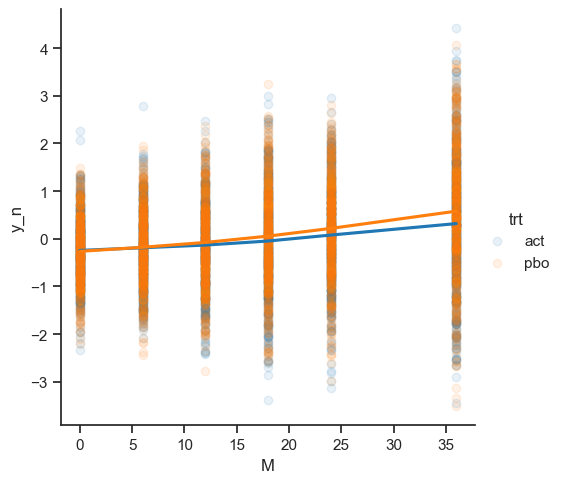

In [6]:
# visualize raw data
sns.lmplot(data=df, x="M", y="y_n",hue="trt",lowess=True,scatter_kws={"alpha":0.1})
#plt.tight_layout()
plt.show()

In [7]:
# model data, convert to numpyro tensors
dat={   
        # number of groups
        #"n_trt":df.trt.cat.categories.size,
        "n_id": df.id.cat.categories.size,
        #"n_mod_trt":df.mod_trt.cat.categories.size,
        "n_trt":df.trt.cat.categories.size,
        "n_visit":df.visit.cat.categories.size,

        # actual data
        #"act_vis":jnp.array(df.act_vis.cat.codes),
        "visit":jnp.array(df.visit.cat.codes),
        "id":jnp.array(df.id.cat.codes),
        "trt":jnp.array(df.trt.cat.codes),
        #"mod_trt":jnp.array(df.mod_trt.cat.codes),

        "M":  jnp.array(df.M),
        "y": jnp.array(df.y_n),
    }


## Mixed models for repeated measures

In [8]:
# original version in R 
# mmrm_alt <- lmer(y ~ act_vis + 0 + (as.factor(visit) + 0 | id),
#              data = dat,
#              control = lmerControl(check.nobs.vs.nRE = 'ignore',
#                                    optimizer = 'optimx',
#                                    optCtrl = list(method = 'L-BFGS-B')))

# equivalent to the R version in https://github.com/vfonov/PMRM/blob/main/1_fit_models.R#L63

def MMRM_model(n_id=1,
               n_trt=2, 
               n_visit=0,   
                # categorical
               id=None, 
               trt=None,
               visit=None,
                # continuous
               M=None,y=None):
    # 
    # hyperpriors
    non_informative_sigma  = 10.0

    # prior for fixed effect variability
    sigma_trt_vis   = numpyro.sample("sigma_trt_vis", dist.HalfCauchy(non_informative_sigma) )

    # fixed effects
    mu_0_vis_z      = numpyro.sample("mu_0_vis_z",   dist.Normal(0.0,1.0))
    mu_trt_vis_z    = numpyro.sample("mu_trt_vis_z", dist.Normal(0.0,1.0).expand([n_trt, n_visit-1]))

    # generate fixed effect, where there is no treatment effect at the first visit
    mu_trt_vis      = numpyro.deterministic("mu_trt_vis", 
        jnp.concatenate((jnp.stack((mu_0_vis_z, mu_0_vis_z),)[:,None], mu_trt_vis_z ),axis=1) * sigma_trt_vis )

    # subject level (random effects)
    sigma_id_vis   = numpyro.sample("sigma_id_vis", dist.HalfCauchy(non_informative_sigma) )
    mu_id_vis_z    = numpyro.sample("mu_id_vis_z",  dist.Normal(0.0, 1.0).expand([n_visit,n_id]) )
    mu_id_vis      = numpyro.deterministic("mu_id_vis", mu_id_vis_z*sigma_id_vis)

    # prediction
    mu = numpyro.deterministic("mu", mu_trt_vis[trt, visit] + mu_id_vis[visit, id])
    sigma = numpyro.sample("sigma",  dist.HalfCauchy(non_informative_sigma).expand([n_visit]) )
    # likelihood
    numpyro.sample("y", dist.Normal(mu, sigma[visit]), obs=y)
    

In [9]:
n_samp=1000
n_warm=500
n_ch=8
acc_rate=0.8
chain_method="parallel"
#chain_method="sequential"

mcmc = MCMC(NUTS(MMRM_model,target_accept_prob=acc_rate), 
    num_warmup=n_warm, num_samples=n_samp, num_chains=n_ch, 
    chain_method=chain_method, 
    progress_bar=(chain_method=="sequential")) 

mcmc.run(rng_key,**dat)

print("Number of divergences: ", mcmc.get_extra_fields()["diverging"].sum())

Number of divergences:  963


In [10]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu_0_vis_z     -1.03      0.26     -1.01     -1.43     -0.60    472.01      1.02
  mu_id_vis_z[0,0]     -0.27      0.87     -0.32     -1.67      1.18    162.69      1.03
  mu_id_vis_z[0,1]      0.21      0.81      0.25     -1.11      1.56   1116.18      1.01
  mu_id_vis_z[0,2]      0.26      0.83      0.30     -1.11      1.68    285.48      1.03
  mu_id_vis_z[0,3]      0.36      0.87      0.45     -1.09      1.70    117.89      1.03
  mu_id_vis_z[0,4]     -0.32      0.85     -0.36     -1.68      1.11    135.32      1.03
  mu_id_vis_z[0,5]      0.17      0.81      0.21     -1.24      1.47    861.01      1.01
  mu_id_vis_z[0,6]      0.29      0.83      0.35     -1.11      1.62    525.61      1.02
  mu_id_vis_z[0,7]     -0.65      0.91     -0.78     -2.05      0.91     37.80      1.08
  mu_id_vis_z[0,8]      0.34      0.85      0.43     -1.03      1.72    139.96      1.04
  mu_id_vis_z[0,9]  

In [11]:
post = mcmc.get_samples()
az_mcmc=az.from_numpyro(mcmc,
            coords={"visit":df.visit.cat.categories,
                    "trt":df.trt.cat.categories,
                    },
            dims=  {
                    "mu_trt_vis":  ["trt","visit"],
                        }
            )

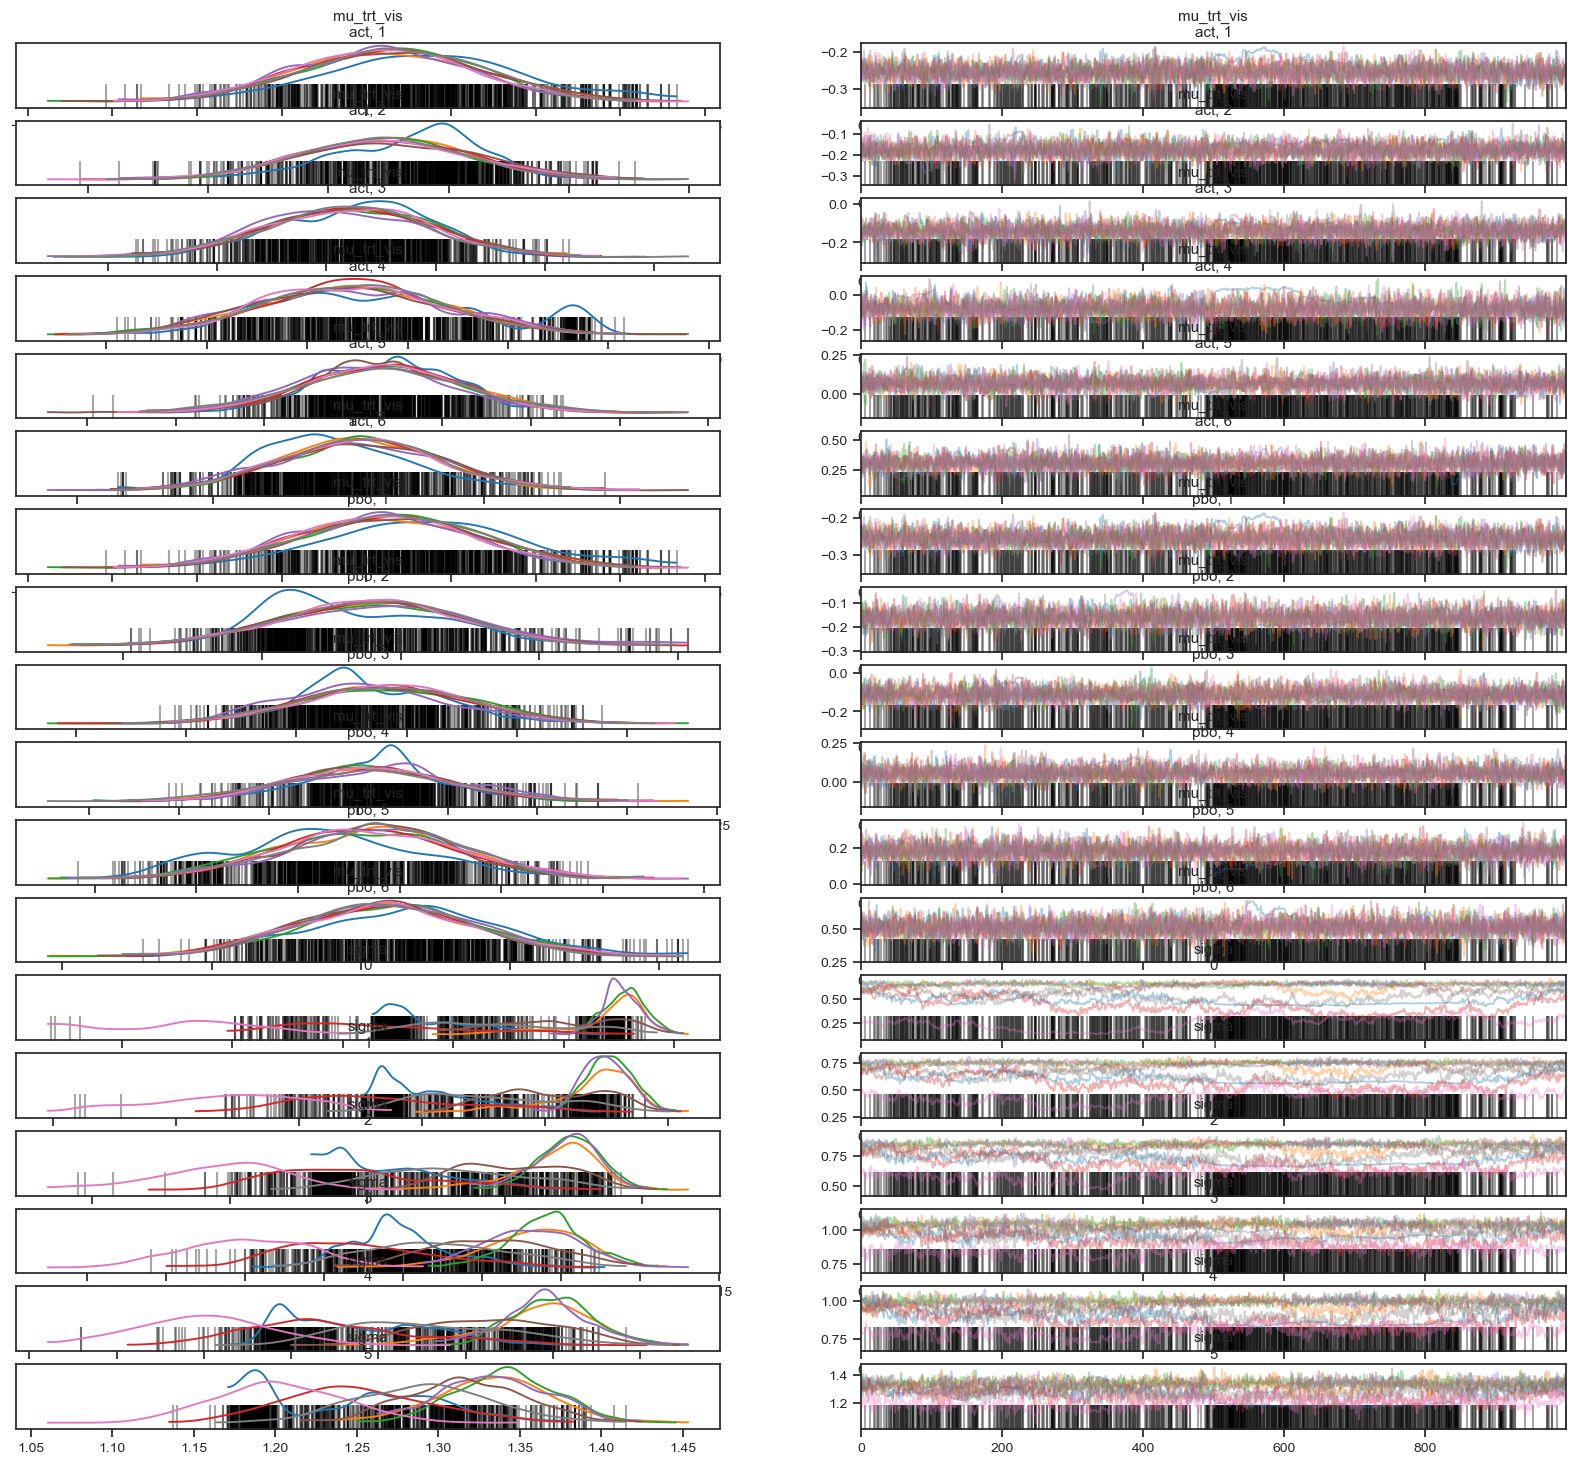

In [12]:
g=az.plot_trace(az_mcmc,var_names=["mu_trt_vis","sigma"], compact=False, figsize=(20,18))
plt.show()

## Compare results with R version

In [13]:
# results from R
#  Coefficients:
#  act_vispbo.0  act_visact.6  act_vispbo.6 act_visact.12 act_vispbo.12 
#      19.70209      20.33682      20.73719      20.68663      21.25419 
# act_visact.18 act_vispbo.18 act_visact.24 act_vispbo.24 act_visact.36 
#      21.27501      22.97244      22.76961      24.28000      25.30778 
# act_vispbo.36 
#      27.86815 
jnp.median(post["mu_trt_vis"],axis=0)*std.y+mean.y

Array([[19.7244277 , 20.50755469, 20.8610563 , 21.47663424, 22.90039716,
        25.27412561],
       [19.7244277 , 20.64615509, 21.12531681, 22.81014291, 24.05641076,
        27.38358926]], dtype=float64)

/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


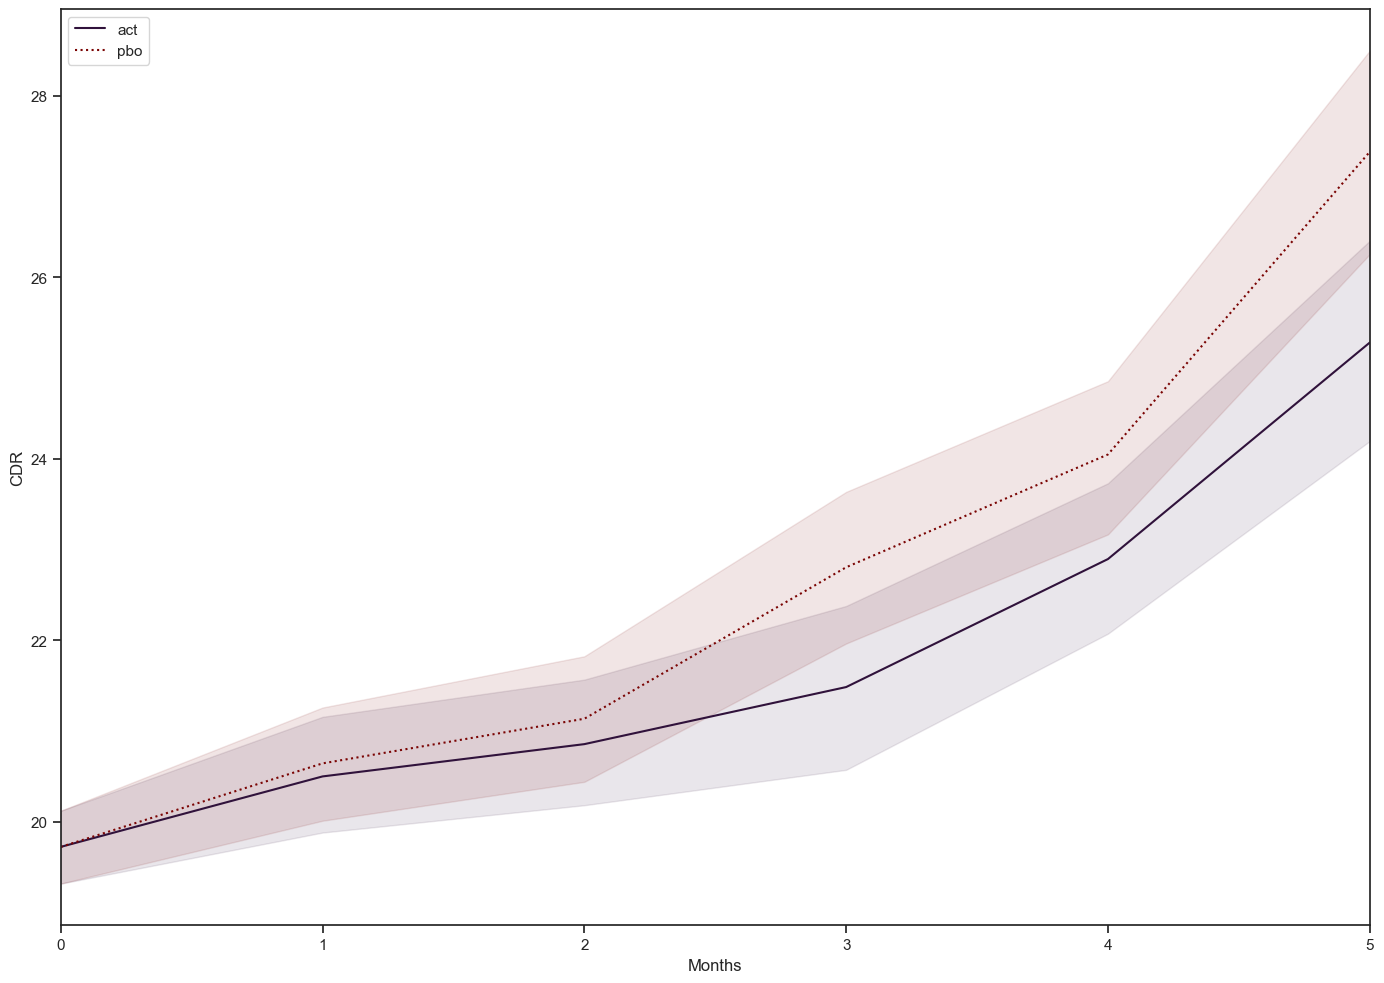

In [14]:
# plot group trajectories
fig,  ax = plt.subplots(
    ncols=1 ,
    nrows=1, sharex=True, sharey=True, figsize=(14, 10))

#print(surv_ax.shape)
cmap = mpl.colormaps['turbo'].resampled(df.trt.cat.categories.size)

# shift right, because values correspond to the right edges of time periods
#interval_bounds_ = interval_bounds + interval_length
visits=np.arange(df.visit.cat.categories.size)

for trt in range(df.trt.cat.categories.size):
    # calculate accumulated hazard at the END of the period
    mu = (post["mu_trt_vis"]*std.y+mean.y)[:,trt,:]

    az.plot_hdi(visits,  mu, 
        ax=ax, smooth=False, color=cmap(trt),
        plot_kwargs={"linestyle":["-",":"][trt]},
        fill_kwargs={'alpha': 0.1}) # 
    
    ax.plot(visits, 
                            mu.mean(axis=0), 
                            color=cmap(trt), 
                            linestyle=["-",":"][trt],
                            label=f"{df.trt.cat.categories[trt]}")

    ax.set_xlim(0, visits.max())
    ax.legend()


ax.set_ylabel("CDR")

ax.set_xlabel("Months")

fig.tight_layout()

# Time-PMRM model with piece-wise linear model 

incomplete equivalent to https://github.com/vfonov/PMRM/blob/main/1_fit_models.R#L126

In [15]:

# implement time delay model , with linear interpolation
def TPMRM_model(n_id=1,
               n_trt=2, 
               n_visit=0,
               n_knots=0,
                # categorical
               id=None, 
               trt=None,
               visit=None,
                # continuous
               knots=None, # interpolation knots
               M_n=None,
               M=None,
               y=None):
    
    # hyperpriors
    non_informative_sigma  = 1.0

    # prior time knot values variability
    sigma_v   = numpyro.sample("sigma_v", dist.HalfCauchy(non_informative_sigma) )
    # prior time knot values variability
    mu_v   = numpyro.sample("mu_v", dist.Normal(0.0,1.0) )

    # fixed effects : time knots
    v_z      = numpyro.sample("v_z",   dist.Normal(0.0,1.0).expand([n_knots]))

    # shifts
    b_z      = numpyro.sample("b_z",   dist.Normal(0.0,1.0))

    # generate fixed effect
    v        = numpyro.deterministic("v",   v_z*sigma_v+mu_v ) 
    b        = numpyro.deterministic("b",
        jnp.vstack((jnp.zeros(n_knots), jnp.concatenate((jnp.array([0.0]), jnp.ones(n_knots-1)*b_z )) )) ) 
        
    # subject level (random effects)
    sigma_id   = numpyro.sample("sigma_id", dist.HalfCauchy(non_informative_sigma) )
    mu_id_z    = numpyro.sample("mu_id_z",  dist.Normal(0.0,1.0).expand([n_id]) )
    mu_id      = numpyro.deterministic("mu_id", mu_id_z*sigma_id)


    # prediction
    # time shift
    t  = numpyro.deterministic("t",  M_n * (1.0- b[trt,visit])  )
    mu = numpyro.deterministic("mu", jnp.interp(t,knots,v)[visit] + mu_id[id])

    # variance of the residuals, should it be by visit?
    sigma = numpyro.sample("sigma",  dist.HalfCauchy(non_informative_sigma).expand([n_visit]) )
    
    # likelihood
    numpyro.sample("y", dist.Normal(mu, sigma[visit]), obs=y)

In [16]:
dat.update({
    "n_knots":5,
    "knots": jnp.linspace(0.0,1.0,5),
    "M_n": dat["M"]/dat["M"].max(),
})
dat

{'n_id': 1000,
 'n_trt': 2,
 'n_visit': 6,
 'visit': Array([0, 1, 2, ..., 3, 4, 5], dtype=int8),
 'id': Array([  0,   0,   0, ..., 999, 999, 999], dtype=int16),
 'trt': Array([1, 1, 1, ..., 0, 0, 0], dtype=int8),
 'M': Array([ 0.,  6., 12., ..., 18., 24., 36.], dtype=float64),
 'y': Array([-0.64622021, -0.62181463,  0.07478632, ...,  2.82972121,
         2.94865491,  3.92985734], dtype=float64),
 'n_knots': 5,
 'knots': Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float64),
 'M_n': Array([0.        , 0.16666667, 0.33333333, ..., 0.5       , 0.66666667,
        1.        ], dtype=float64)}

In [17]:
n_samp=1000
n_warm=500
n_ch=8
acc_rate=0.8
chain_method="parallel"
#chain_method="sequential"

mcmc = MCMC(NUTS(TPMRM_model,target_accept_prob=acc_rate), 
    num_warmup=n_warm, num_samples=n_samp, num_chains=n_ch, 
    chain_method=chain_method, 
    progress_bar=(chain_method=="sequential")) 


mcmc.run(rng_key,**dat)

print("Number of divergences: ", mcmc.get_extra_fields()["diverging"].sum())

Number of divergences:  0


In [18]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         b_z      0.55      0.24      0.46      0.27      0.95      4.50      3.51
  mu_id_z[0]      0.42      0.87      0.01     -0.37      2.03      4.16      6.30
  mu_id_z[1]     -0.09      0.74     -0.18     -1.32      1.41      4.17      6.24
  mu_id_z[2]      0.42      0.96      0.57     -1.72      1.71      4.07      9.18
  mu_id_z[3]      0.66      0.81      0.41     -0.41      1.72      4.21      5.73
  mu_id_z[4]     -0.24      0.87     -0.45     -1.03      1.78      4.12      7.24
  mu_id_z[5]      0.41      1.12      0.78     -1.59      1.59      4.11      9.35
  mu_id_z[6]      0.24      0.93      0.34     -1.30      1.72      4.08      7.83
  mu_id_z[7]     -0.21      0.75     -0.04     -2.11      0.54      4.14      6.64
  mu_id_z[8]      0.50      0.74      0.67     -0.76      1.66      4.26      5.63
  mu_id_z[9]      0.06      0.44     -0.03     -0.62      0.66      8.42      2.51
 mu

In [19]:
post = mcmc.get_samples()
az_mcmc=az.from_numpyro(mcmc,
            coords={"visit":df.visit.cat.categories,
                    "trt":df.trt.cat.categories,
                    "knots":dat['knots']
                    },
            dims=  {
                    "b":  ["trt","knots"],
                    "v":  ["knots"],
                        }
            )

/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


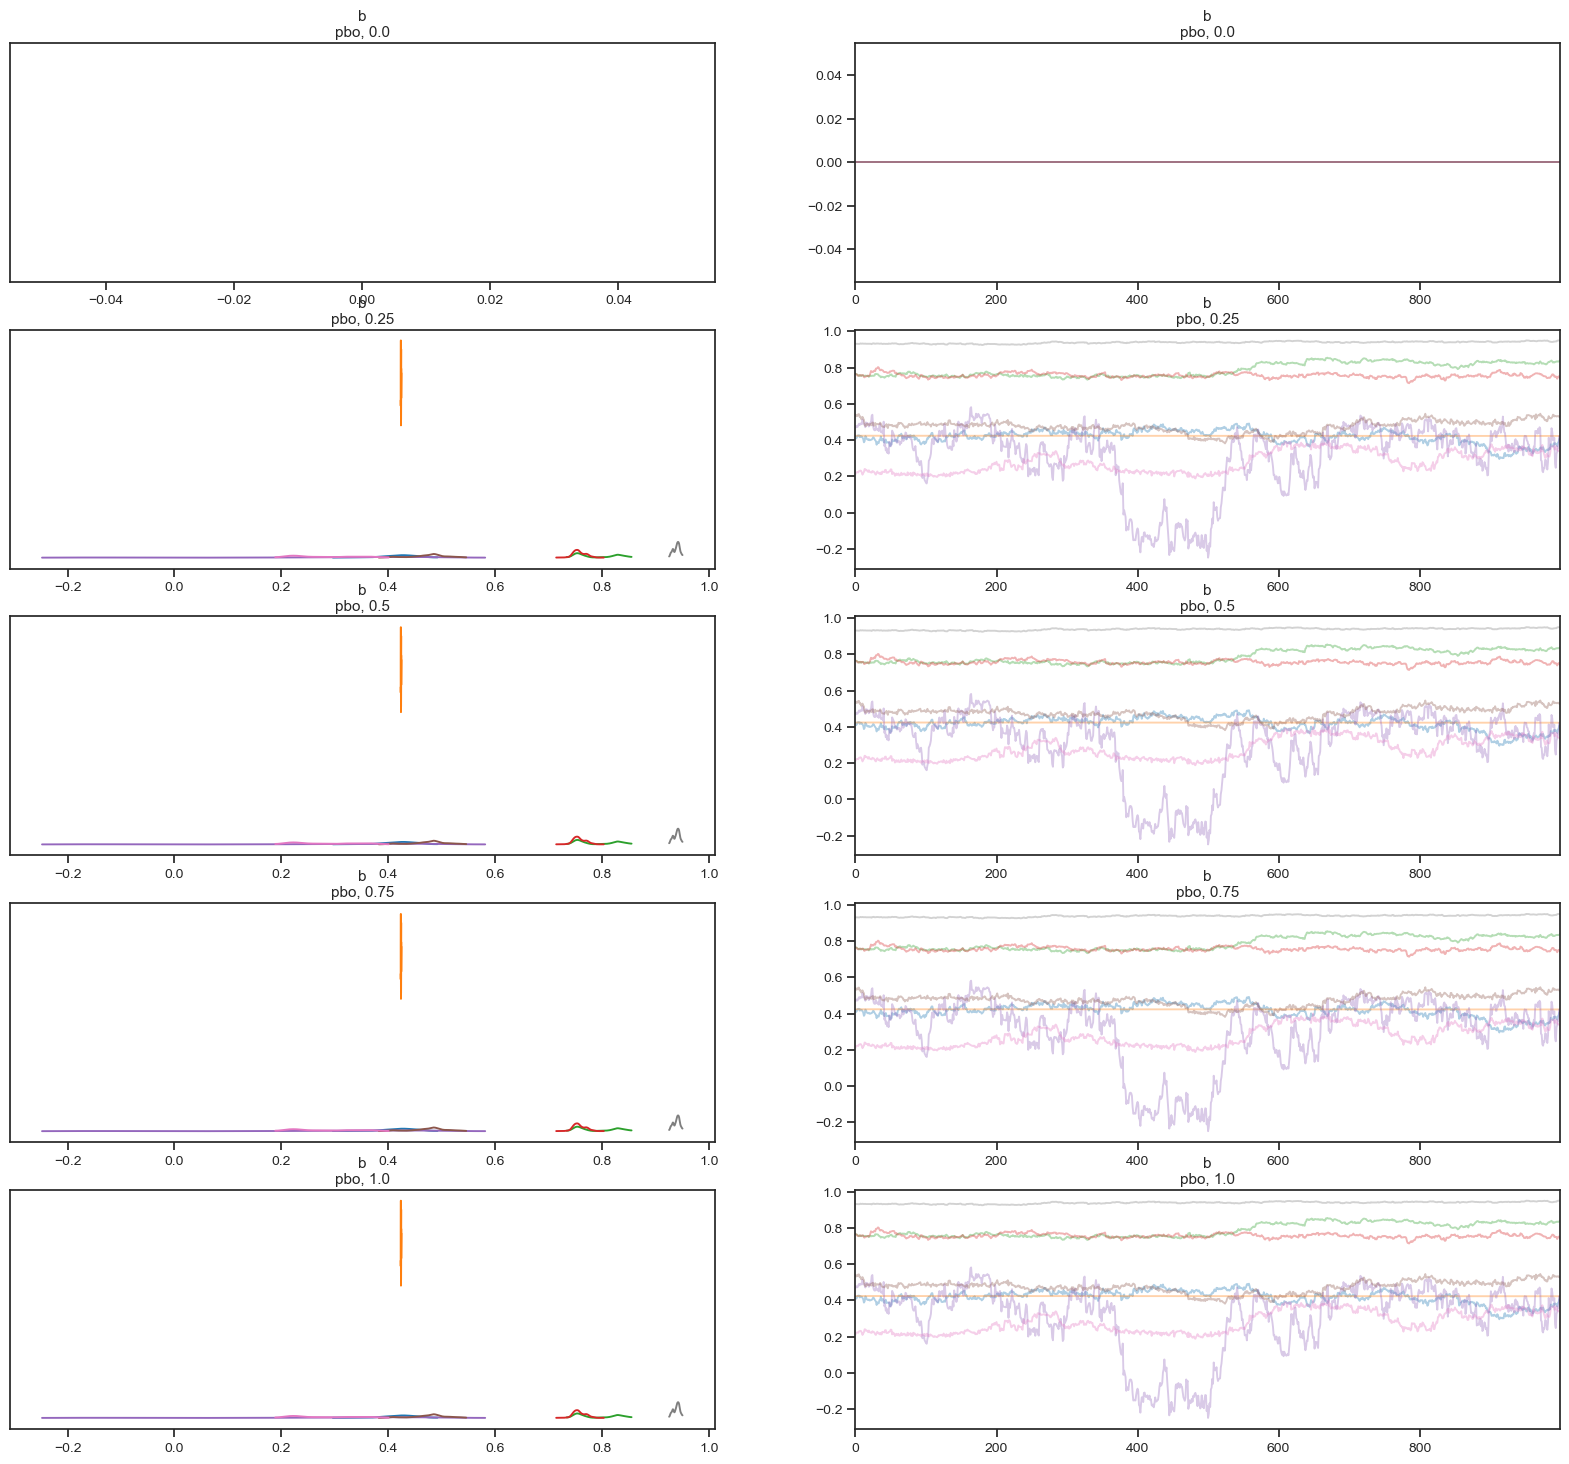

In [20]:
g=az.plot_trace(az_mcmc, var_names=["b"], compact=False, figsize=(20,18),coords = {'trt': [df.trt.cat.categories[1]]})
plt.show()

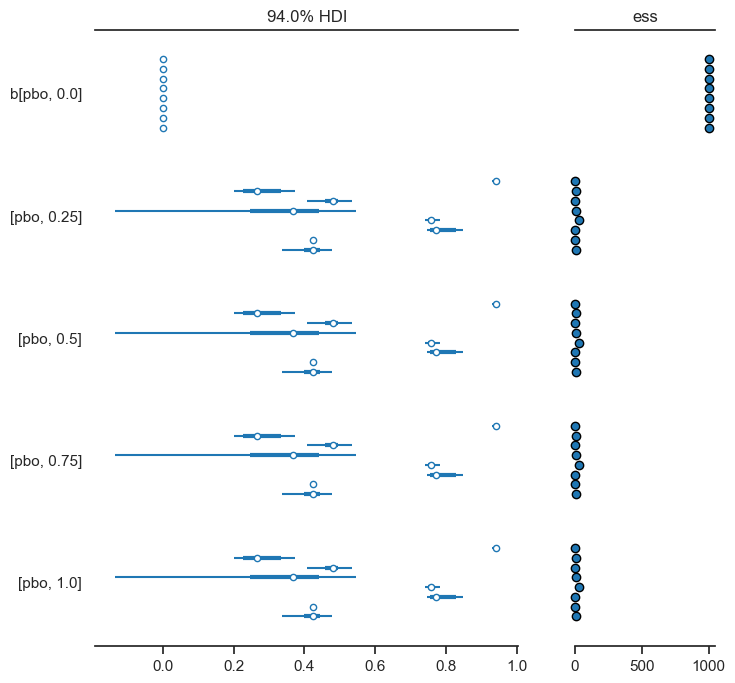

In [21]:
g=az.plot_forest(az_mcmc,var_names=["b"],coords = {'trt': [df.trt.cat.categories[1]]},ess=True)
plt.show()

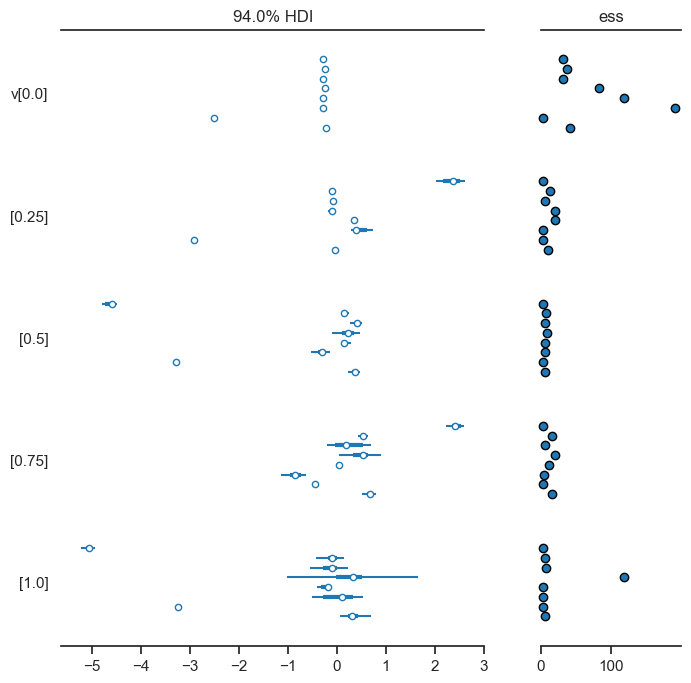

In [22]:
g=az.plot_forest(az_mcmc,var_names=["v"],ess=True)
plt.show()

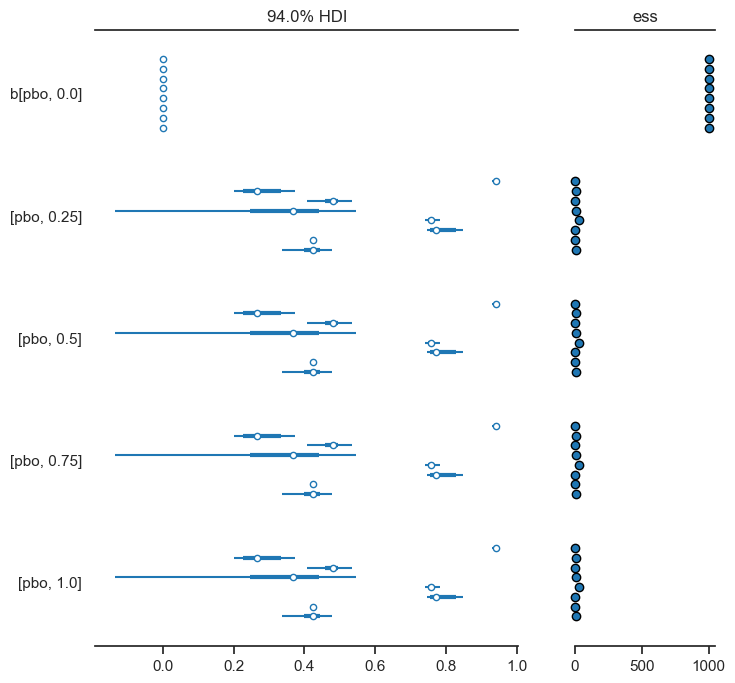

In [23]:
g=az.plot_forest(az_mcmc,var_names=["b"],coords = {'trt': [df.trt.cat.categories[1]]},ess=True)
plt.show()

v.shape=(8000, 5) t.shape=(8000, 5) 
mu.shape=(8000, 5) v.shape=(8000, 5)
t.mean(axis=0)=Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float64)
v.shape=(8000, 5) t.shape=(8000, 5) 
mu.shape=(8000, 5) v.shape=(8000, 5)
t.mean(axis=0)=Array([0.        , 0.79860316, 1.04860316, 1.29860316, 1.54860316],      dtype=float64)


/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


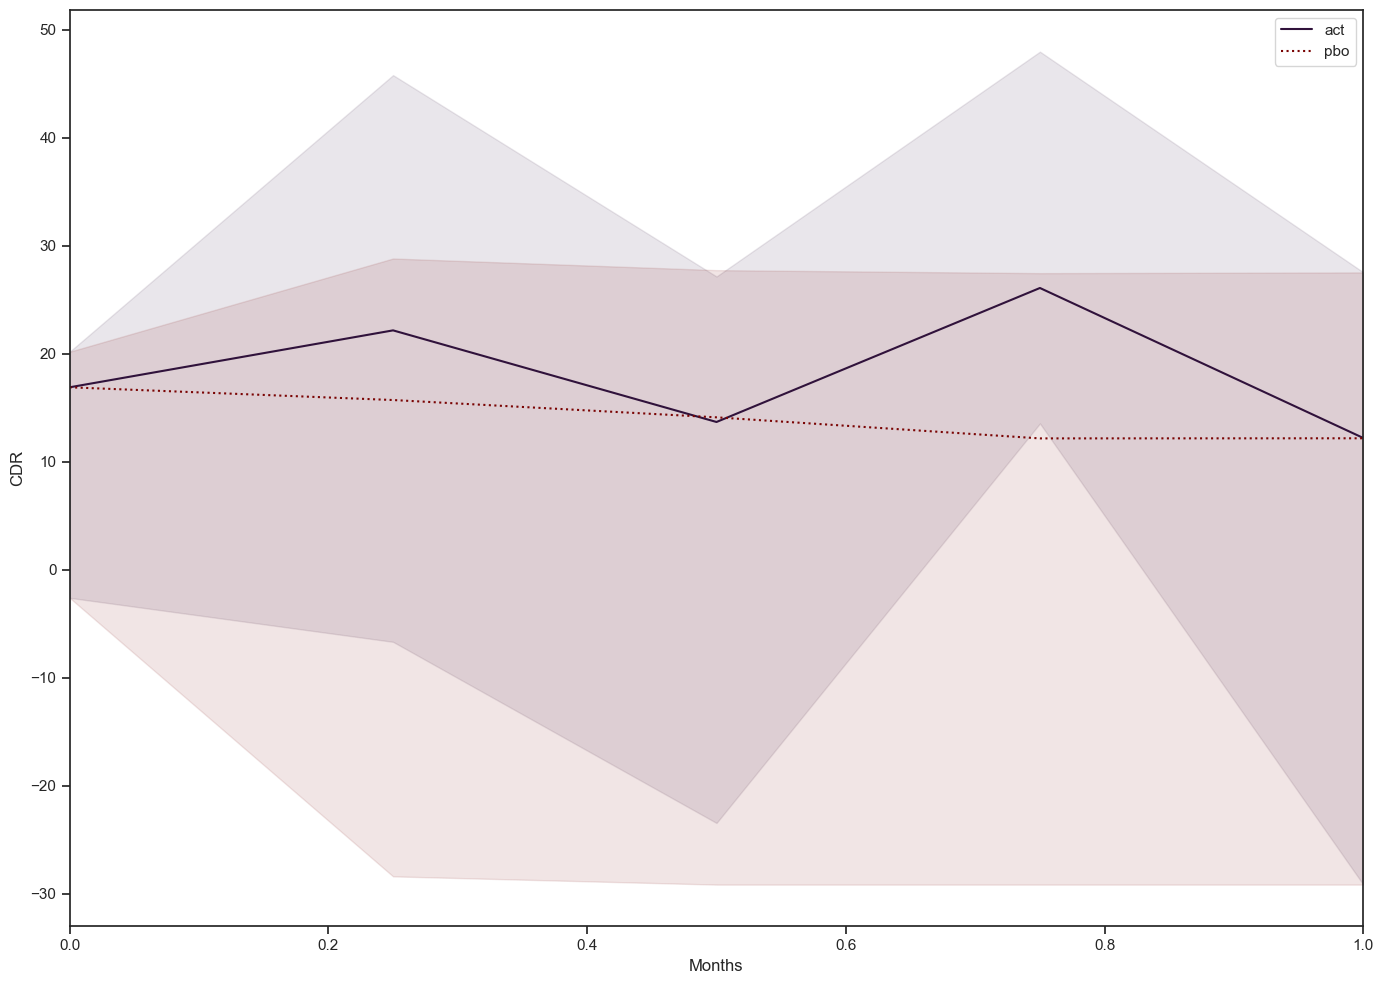

In [24]:
# plot group trajectories
fig,  ax = plt.subplots(
    ncols=1 ,
    nrows=1, sharex=True, sharey=True, figsize=(14, 10))

#print(surv_ax.shape)
cmap = mpl.colormaps['turbo'].resampled(df.trt.cat.categories.size)

# shift right, because values correspond to the right edges of time periods
#interval_bounds_ = interval_bounds + interval_length
visits=np.arange(df.visit.cat.categories.size)
M_n = dat["knots"]

for trt in range(df.trt.cat.categories.size):
    # calculate accumulated hazard at the END of the period
    v = (post["v"]*std.y+mean.y)
    t  = M_n[None,:] + post["b"][:,trt, :]

    print(f'{v.shape=} {t.shape=} ')
    mu = jax.vmap(lambda x,y:jnp.interp(x, M_n, y), in_axes=0, out_axes=0)(t,v)

    print(f'{mu.shape=} {v.shape=}')
    print(f'{t.mean(axis=0)=}')

    az.plot_hdi(M_n,  mu, 
        ax=ax, smooth=False, color=cmap(trt),
        plot_kwargs={"linestyle":["-",":"][trt]},
        fill_kwargs={'alpha': 0.1}) # 
    
    ax.plot(M_n, 
            mu.mean(axis=0), 
            color=cmap(trt), 
            linestyle=["-",":"][trt],
            label=f"{df.trt.cat.categories[trt]}")

    ax.set_xlim(0, M_n.max())
    ax.legend()


ax.set_ylabel("CDR")

ax.set_xlabel("Months")

fig.tight_layout()

# Time-PMRM model with spline interpolation

equivalent to https://github.com/vfonov/PMRM/blob/main/1_fit_models.R#L126

In [25]:

# implement time delay model , with spline interpolation
def TPMRM_model_spl(n_id=1,
               n_trt=2, 
               n_visit=0,
               n_knots=0,
                # categorical
               id=None, 
               trt=None,
               visit=None,
                # continuous
               knots=None, # interpolation knots
               M_n=None,
               M=None,
               y=None):
    
    # hyperpriors
    non_informative_sigma  = 1.0

    # prior time knot values variability
    sigma_v   = numpyro.sample("sigma_v", dist.HalfCauchy(non_informative_sigma) )
    # prior time knot values variability
    mu_v   = numpyro.sample("mu_v", dist.Normal(0.0,1.0) )

    # prior shifts variability
    #sigma_b   = numpyro.sample("sigma_b", dist.HalfCauchy(non_informative_sigma) )

    # fixed effects : time knots
    v_z      = numpyro.sample("v_z",   dist.Normal(0.0,1.0).expand([n_knots]))

    # shifts
    b_z      = numpyro.sample("b_z",   dist.Normal(0.0,1.0))

    # generate fixed effect
    v        = numpyro.deterministic("v",   v_z*sigma_v+mu_v ) 
    b        = numpyro.deterministic("b",
        jnp.vstack((jnp.zeros(n_knots), jnp.concatenate((jnp.array([0.0]), jnp.ones(n_knots-1)*b_z )) )) ) 
        
    # subject level (random effects)
    sigma_id   = numpyro.sample("sigma_id", dist.HalfCauchy(non_informative_sigma) )
    mu_id_z    = numpyro.sample("mu_id_z",  dist.Normal(0.0,1.0).expand([n_id]) )
    mu_id      = numpyro.deterministic("mu_id", mu_id_z*sigma_id)


    # prediction
    # time shift
    t  = numpyro.deterministic("t",  M_n * (1.0 - b[trt,visit])  )
    spl = InterpolatedUnivariateSpline(knots, v, k=3,endpoints="natural")
    mu = numpyro.deterministic("mu", spl(t)[visit] + mu_id[id])

    # variance of the residuals, should it be by visit?
    sigma = numpyro.sample("sigma",  dist.HalfCauchy(non_informative_sigma).expand([n_visit]) )
    
    # likelihood
    numpyro.sample("y", dist.Normal(mu, sigma[visit]), obs=y)
    

In [26]:
n_samp=1000
n_warm=500
n_ch=8
acc_rate=0.8
chain_method="parallel"
#chain_method="sequential"

mcmc = MCMC(NUTS(TPMRM_model_spl,target_accept_prob=acc_rate), 
    num_warmup=n_warm, num_samples=n_samp, num_chains=n_ch, 
    chain_method=chain_method, 
    progress_bar=(chain_method=="sequential")) 


mcmc.run(rng_key,**dat)

print("Number of divergences: ", mcmc.get_extra_fields()["diverging"].sum())

Number of divergences:  0


In [27]:
post = mcmc.get_samples()
az_mcmc=az.from_numpyro(mcmc,
            coords={"visit":df.visit.cat.categories,
                    "trt":df.trt.cat.categories,
                    "knots":dat['knots']
                    },
            dims=  {
                    "b":  ["trt","knots"],
                    "v":  ["knots"],
                        }
            )

/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


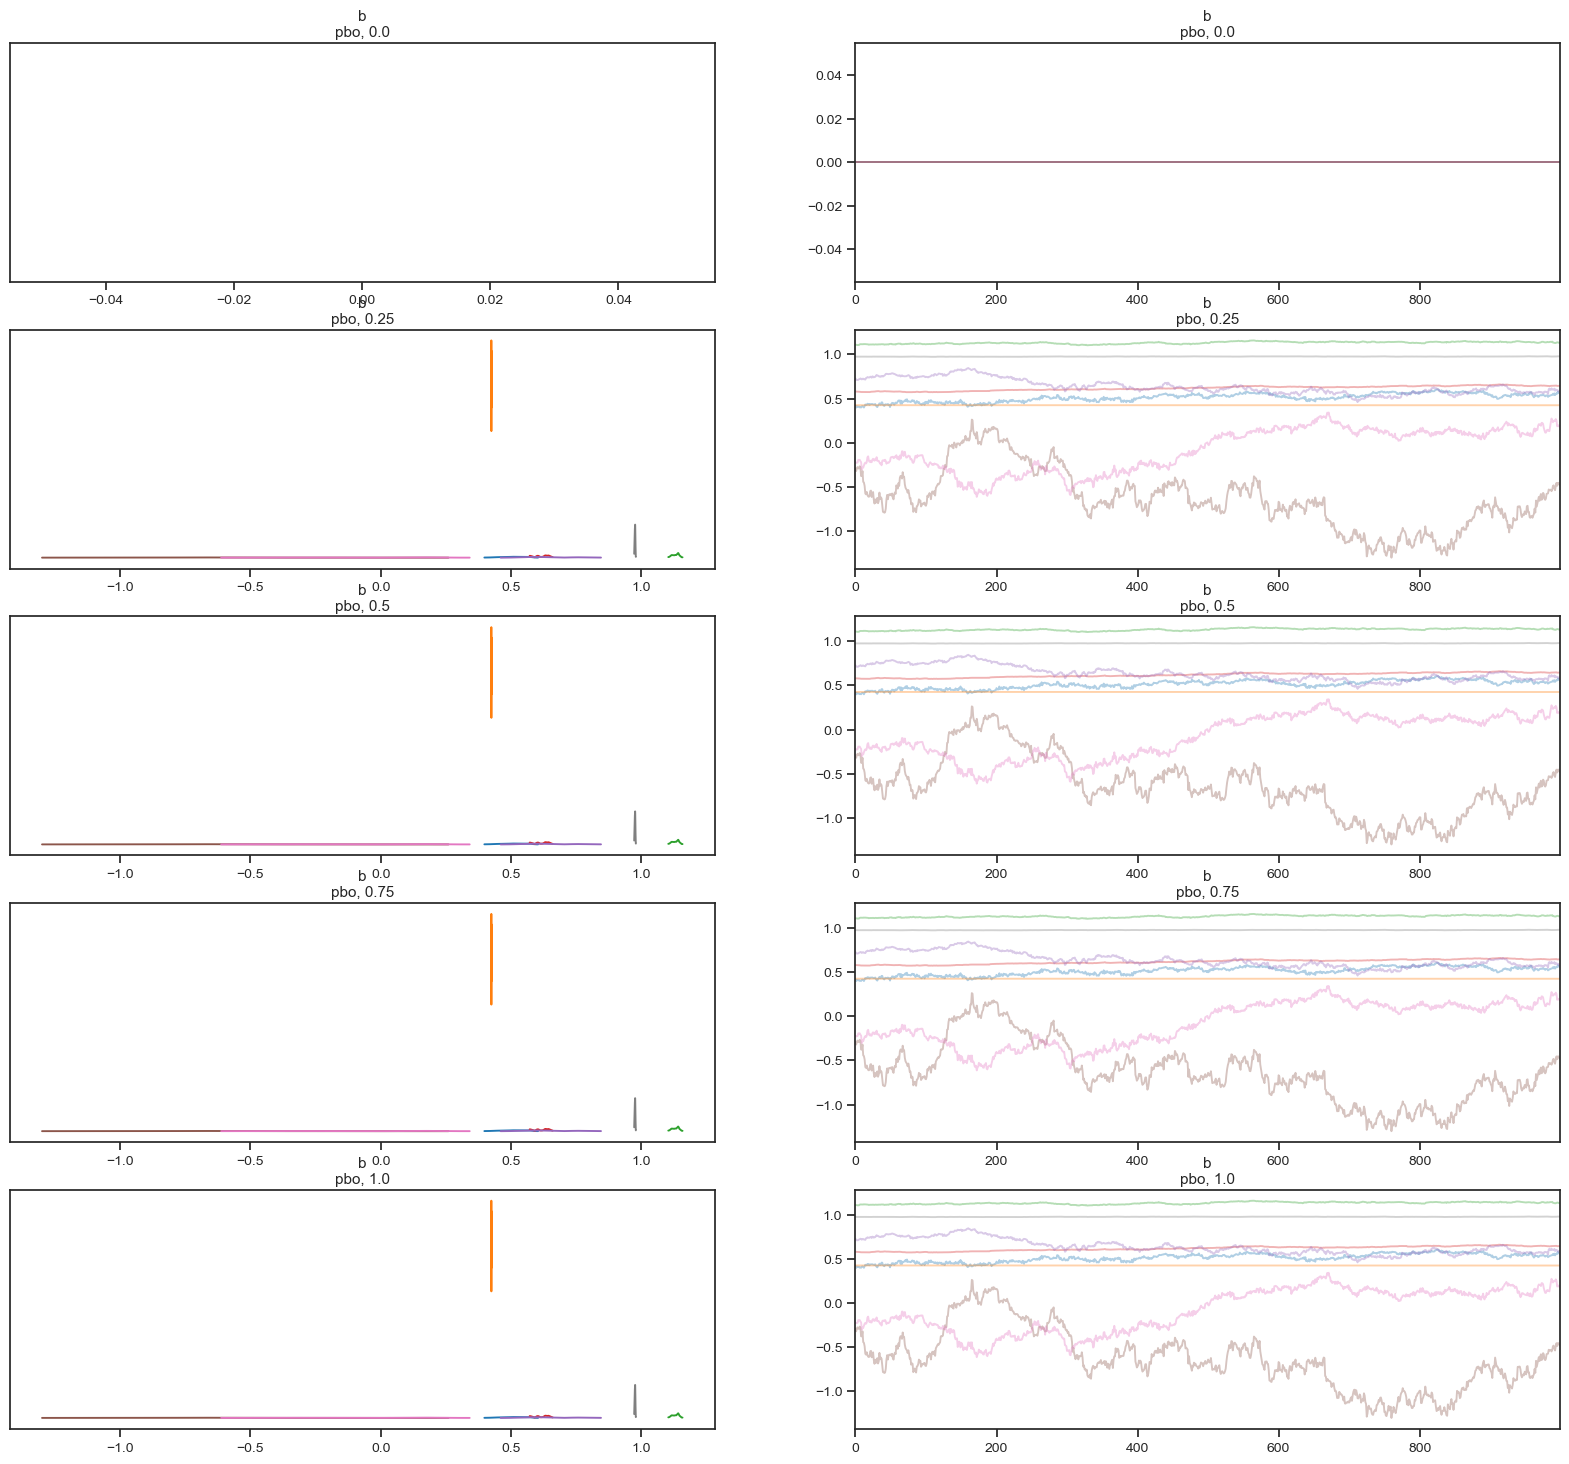

In [28]:
g=az.plot_trace(az_mcmc,var_names=["b"], compact=False, figsize=(20,18),coords = {'trt': [df.trt.cat.categories[1]]})
plt.show()

/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/vfonov/mamba/envs/numpyro3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


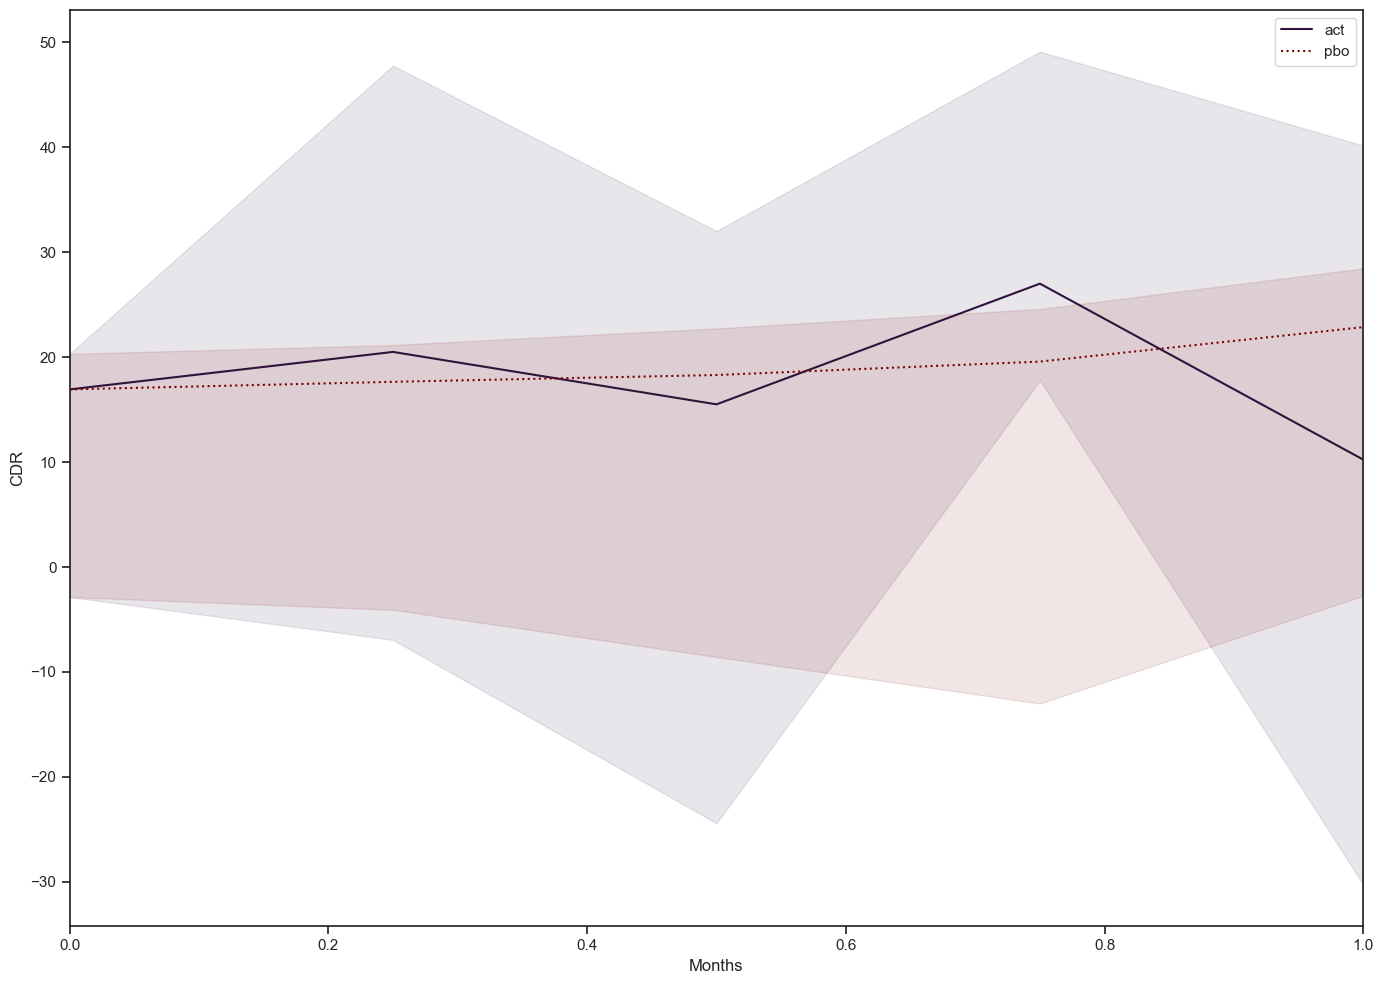

In [29]:
# plot group trajectories
fig,  ax = plt.subplots(
    ncols=1 ,
    nrows=1, sharex=True, sharey=True, figsize=(14, 10))

cmap = mpl.colormaps['turbo'].resampled(df.trt.cat.categories.size)

visits=np.arange(df.visit.cat.categories.size)
M_n = dat["knots"]

for trt in range(df.trt.cat.categories.size):
    v = (post["v"]*std.y+mean.y)
    t  = M_n[None,:] *(1.0 - post["b"][:,trt, :])

    def spl_interp(t,x,y):
        spl = InterpolatedUnivariateSpline(x, y, k=3, endpoints="natural")
        return spl(t)

    mu = jax.vmap(lambda x,y:spl_interp(x, M_n, y), in_axes=0, out_axes=0)(t,v)

    az.plot_hdi(M_n,  mu, 
        ax=ax, smooth=False, color=cmap(trt),
        plot_kwargs={"linestyle":["-",":"][trt]},
        fill_kwargs={'alpha': 0.1}) # 
    
    ax.plot(M_n, 
            mu.mean(axis=0), 
            color=cmap(trt), 
            linestyle=["-",":"][trt],
            label=f"{df.trt.cat.categories[trt]}")

    ax.set_xlim(0, M_n.max())
    ax.legend()


ax.set_ylabel("CDR")

ax.set_xlabel("Months")

fig.tight_layout()